# California Housing Prices Data Set

Create a regression model to predict house prices. See https://www.kaggle.com/camnugent/california-housing-prices for data understanding



## Import packages

In [30]:
! pip install xgboost

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
sns.set()

## Load and inspect data set

In [11]:
# Local: Fetch the file
original_data = pd.read_csv('housing.csv') # Local, use full path if notebook and file in different folders! 

# Cloud: Fetch the file
#my_file = project.get_file("housing.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
#my_file.seek(0)
#original_data = pd.read_csv(my_file)

original_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
original_data.describe(include='all') # descriptive statistics for all columns

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


In [13]:
original_data.isnull().sum() # check for null values

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [14]:
original_data[original_data.duplicated(keep=False)] # check for duplicate rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


There are no duplicates but missing values for "total_bedrooms". Decide what to do with these null values: 

In [16]:
# Musterlösung 
data_wo_null = original_data.dropna(axis=0)
data_wo_null.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Select predictors

Remove redundant features: 

In [ ]:
data_reduced_features = data_wo_null[['<your feature 1>', '<your feature 2>','...']]
data_reduced_features.head()

In [17]:
# Musterlösung
data_reduced_features = data_wo_null[['housing_median_age', 'total_rooms', 'median_income', 
                                      'median_house_value', 'ocean_proximity']] 
                                        
data_reduced_features.head()

,housing_median_age,total_rooms,median_income,median_house_value,ocean_proximity
0,41.0,880.0,8.3252,452600.0,NEAR BAY
1,21.0,7099.0,8.3014,358500.0,NEAR BAY
2,52.0,1467.0,7.2574,352100.0,NEAR BAY
3,52.0,1274.0,5.6431,341300.0,NEAR BAY
4,52.0,1627.0,3.8462,342200.0,NEAR BAY


Create a correlation map:

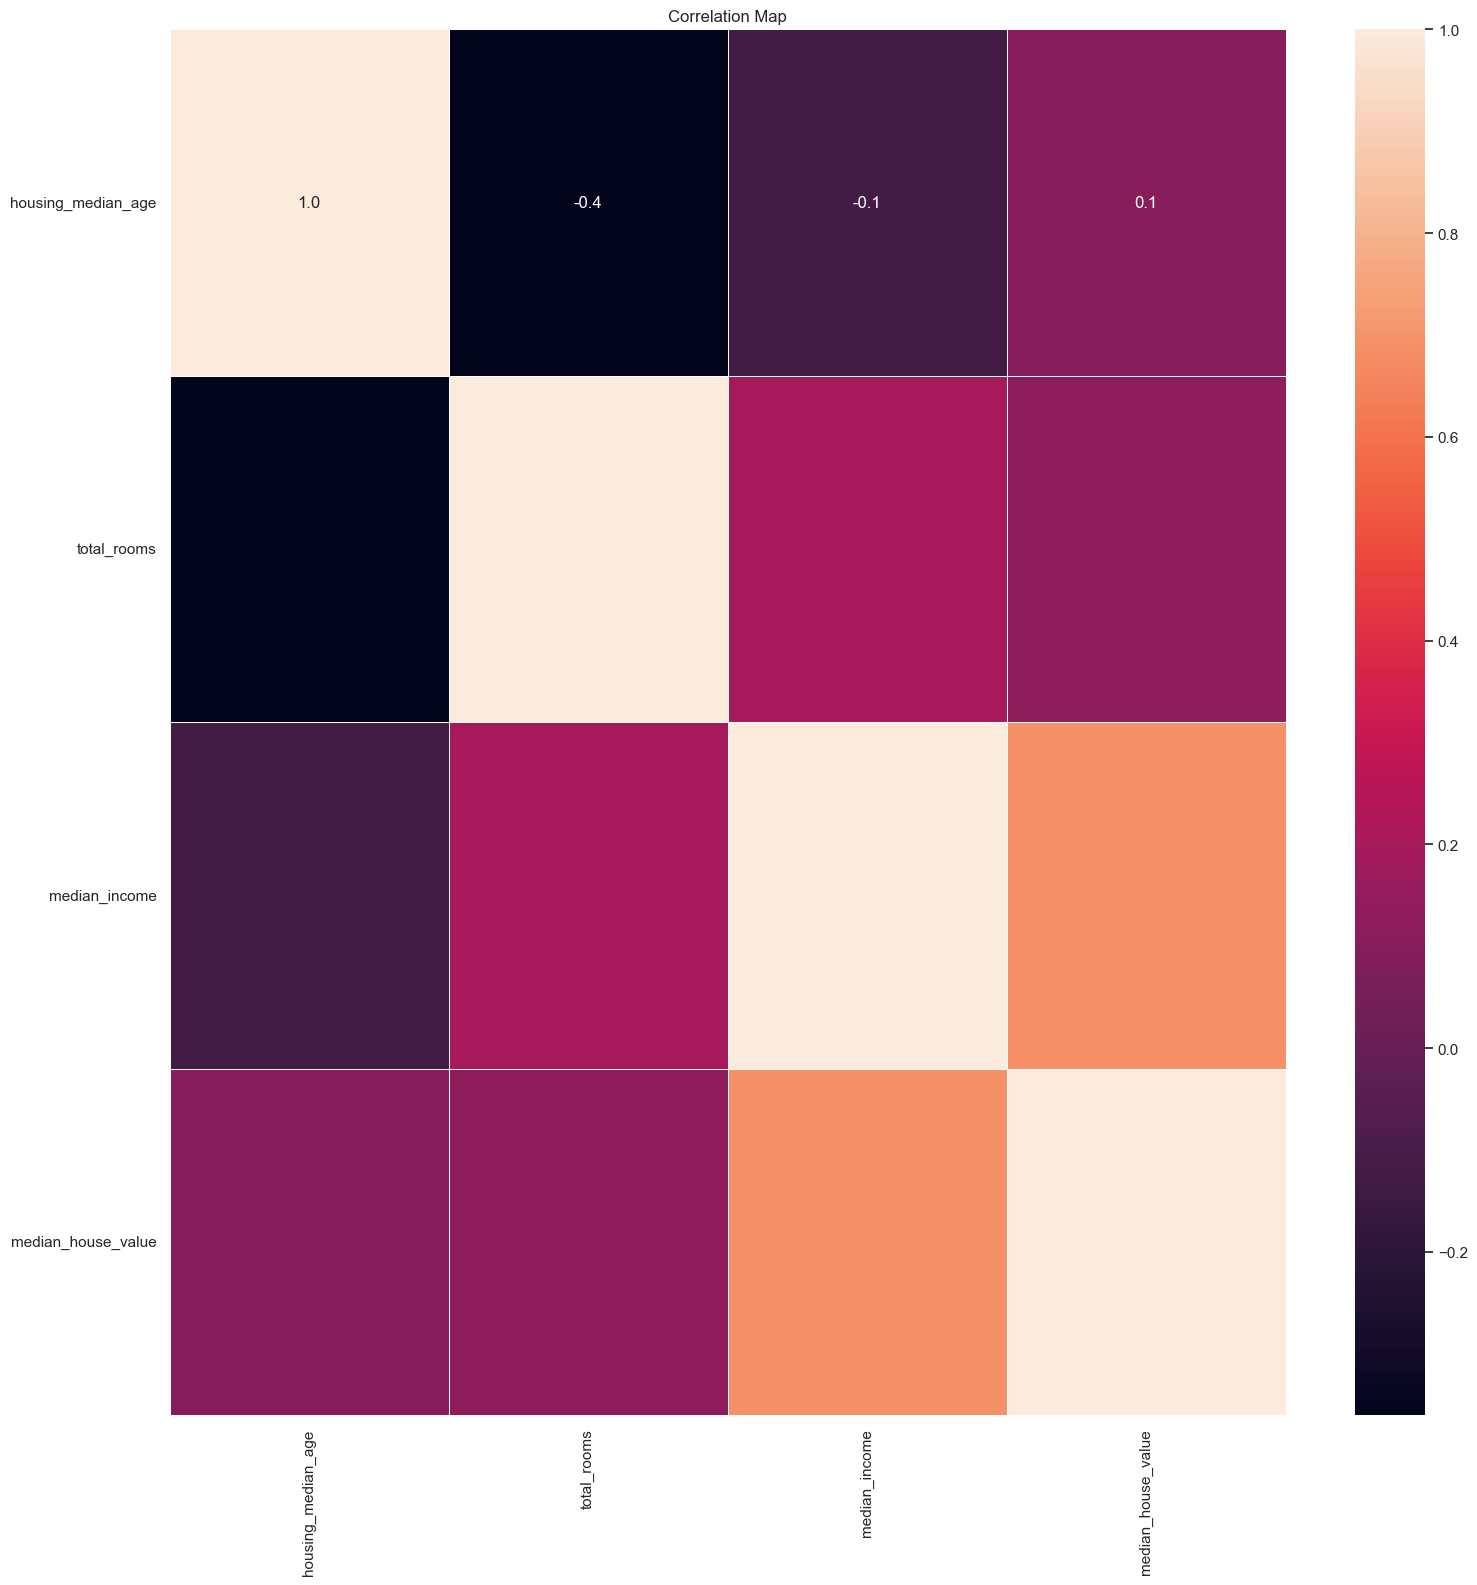

In [18]:
# Musterlösung
# To plot the heatmap we can use only numeric features
data_plot = data_reduced_features[['housing_median_age', 'total_rooms', 'median_income', 'median_house_value']] 
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(data_plot.corr(), annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

## Remove outliers
The next step is to detect outliers and handle them:

array([[<Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

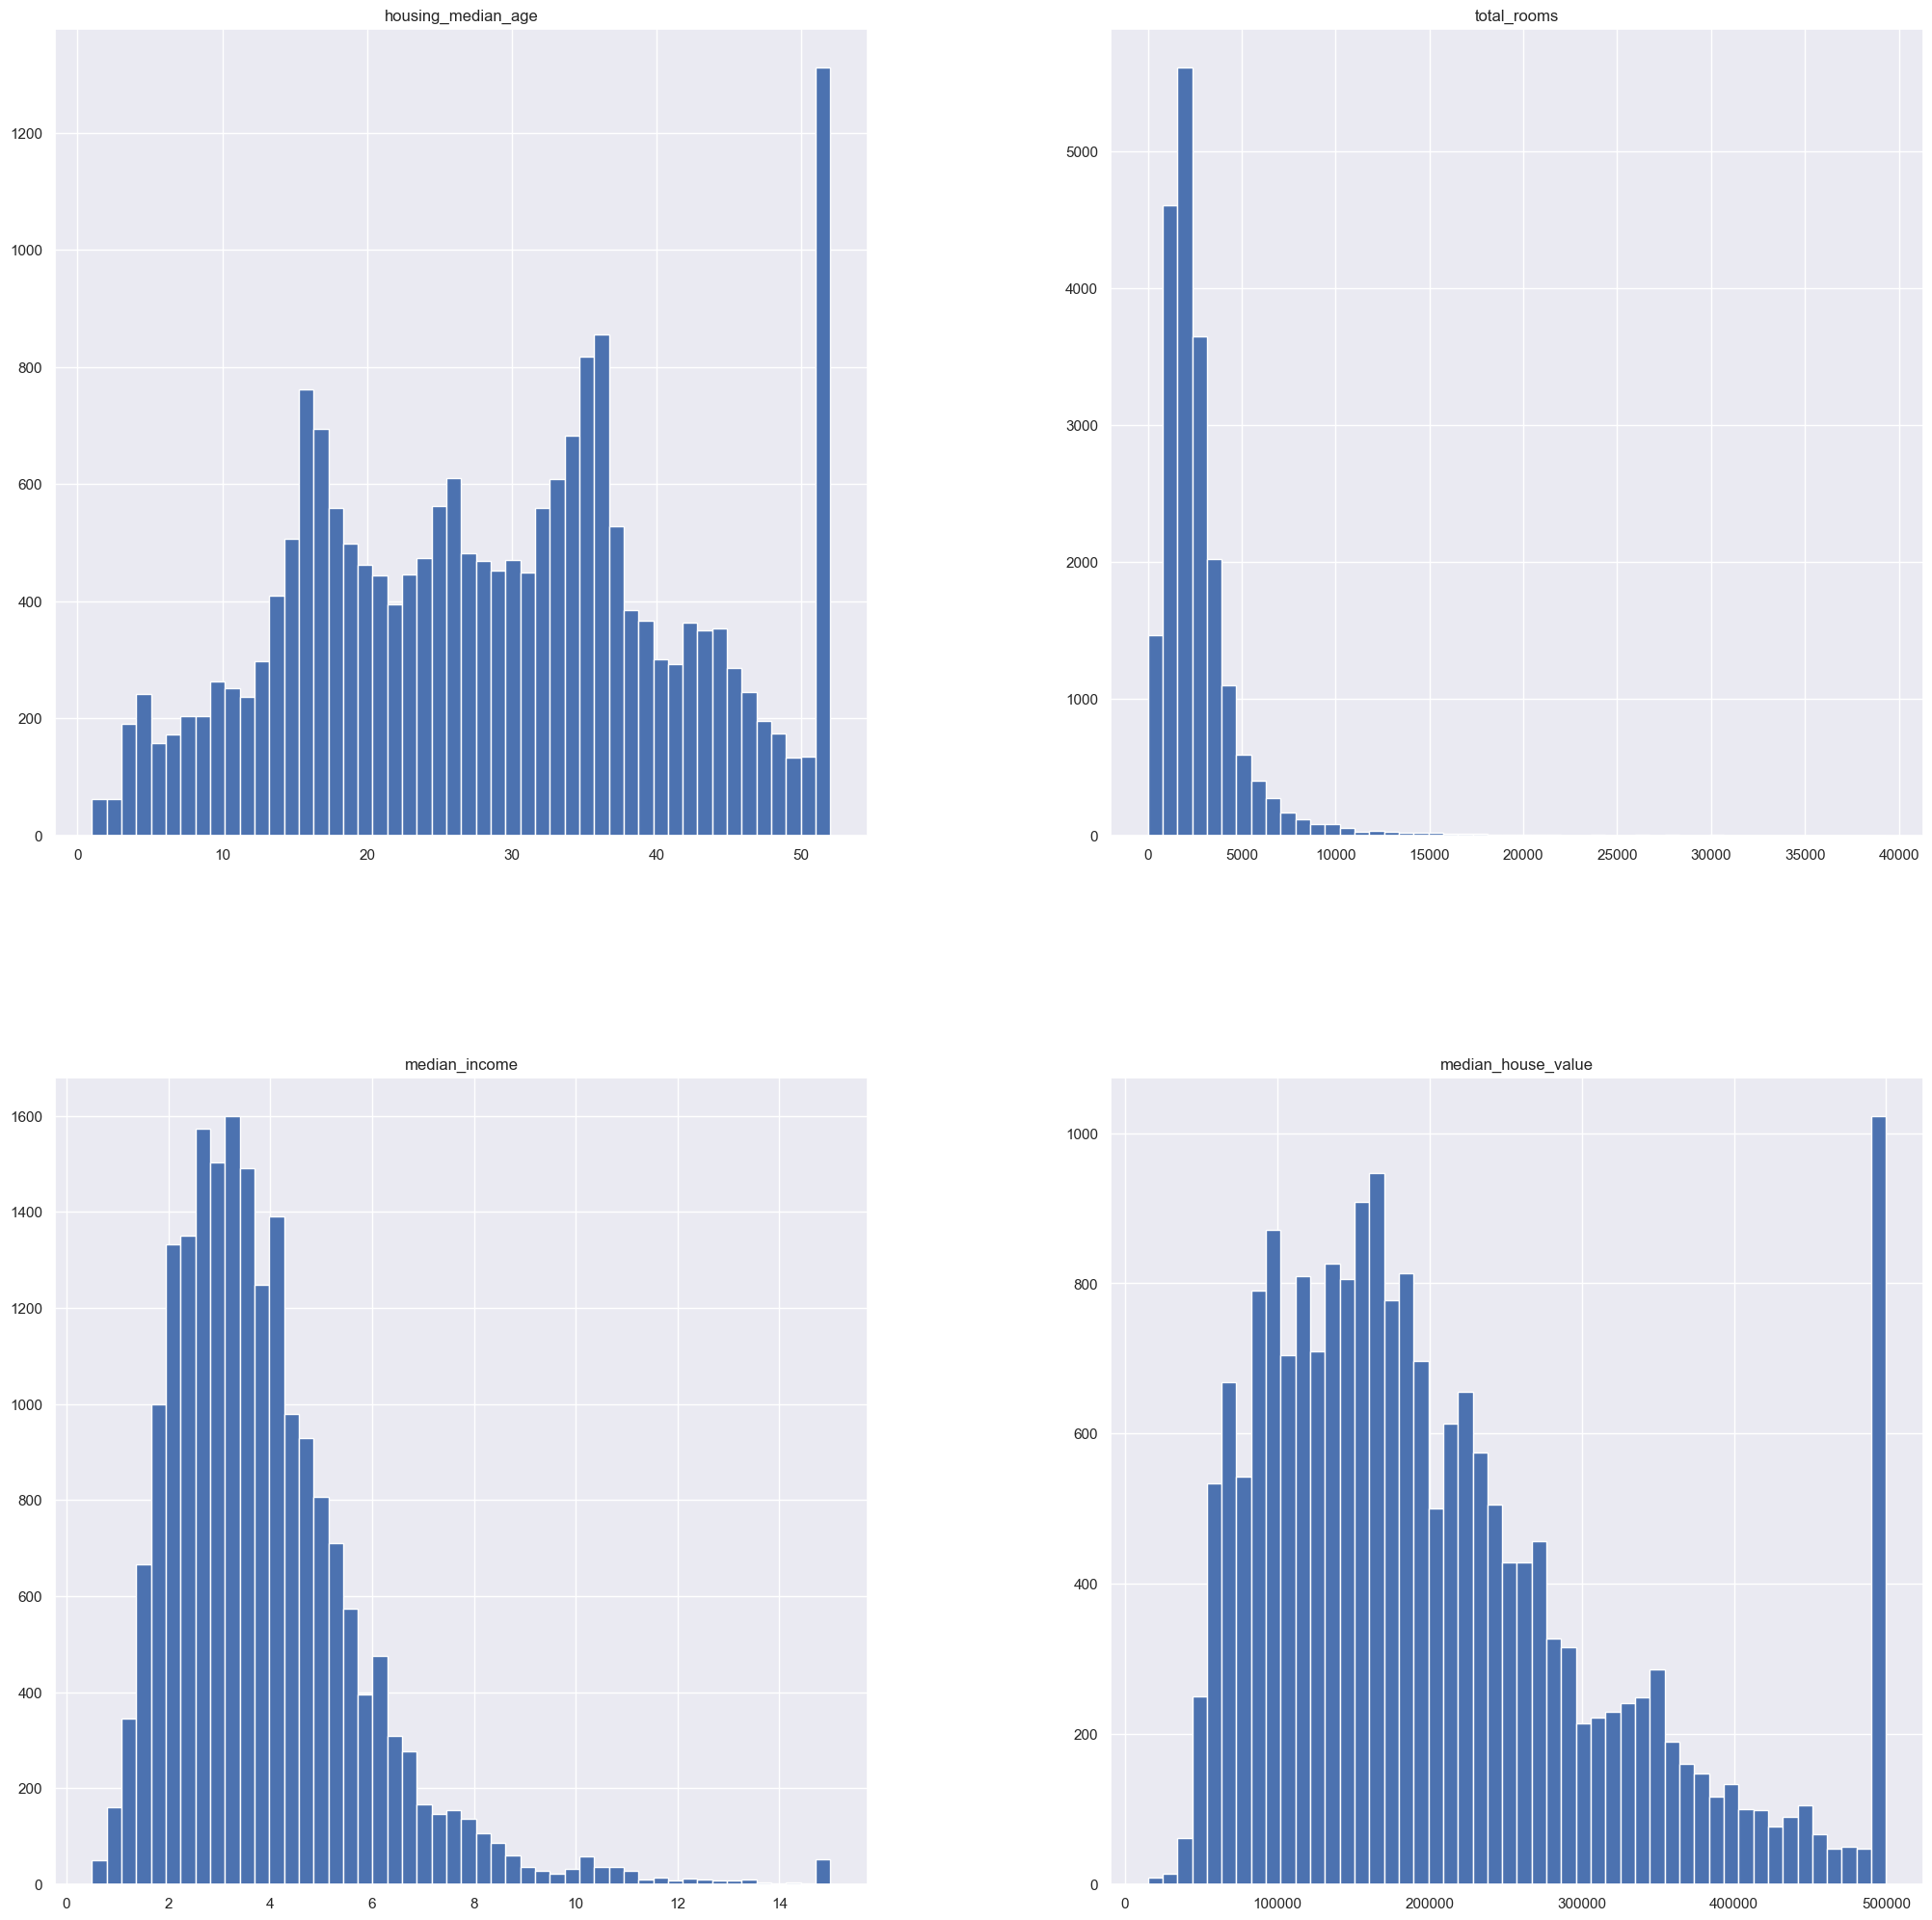

In [19]:
data_reduced_features.hist(figsize=(25,25), bins=50)

In [ ]:
q = # your code

data_reduced_features_2 = # your code

In [20]:
# Musterlösung, total_rooms only, more outliers might be removed! 
q = data_reduced_features['total_rooms'].quantile(0.99)
data_reduced_features_2 = data_reduced_features[data_reduced_features['total_rooms']<q]

## Prepare data for modeling

Get dummies since there is a categorical feature:

In [ ]:
dummies = # your code
dummies.head()

In [21]:
# Musterlösung
dummies = pd.get_dummies(data_reduced_features_2, drop_first=True)
dummies.head()

,housing_median_age,total_rooms,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41.0,880.0,8.3252,452600.0,False,False,True,False
1,21.0,7099.0,8.3014,358500.0,False,False,True,False
2,52.0,1467.0,7.2574,352100.0,False,False,True,False
3,52.0,1274.0,5.6431,341300.0,False,False,True,False
4,52.0,1627.0,3.8462,342200.0,False,False,True,False


Set X and y (predictors and target) according to your dataframe:

In [ ]:
target = dummies['<your target column>']
predictors = # your code

In [22]:
# Musterlösung
target = dummies['median_house_value']
predictors = dummies.drop(['median_house_value'], axis=1)

Split data into training and test sets: 

In [ ]:
X_train, X_test, y_train, y_test = # your code

In [23]:
# Musterlösung
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=123) # 80-20 split into training and test data

Use StandardScaler to scale your predictors:

In [ ]:
scaler = # your code 
# your code

X_train = # your code
X_test = # your code

In [24]:
# Musterlösung

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Regression model and evaluation

Create a linear regression model: 

In [ ]:
# your code

In [25]:
# Musterlösung

reg = LinearRegression()
reg.fit(X_train,y_train)


LinearRegression()

In [26]:
print('training performance')
print(reg.score(X_train,y_train))
print('test performance')
print(reg.score(X_test,y_test))

training performance
0.6021209676697843
test performance
0.5964014538779582


/Users/ellenhoeven/opt/anaconda3/envs/hhz-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenhoeven/opt/anaconda3/envs/hhz-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenhoeven/opt/anaconda3/envs/hhz-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenhoeven/opt/anaconda3/envs/hhz-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_n

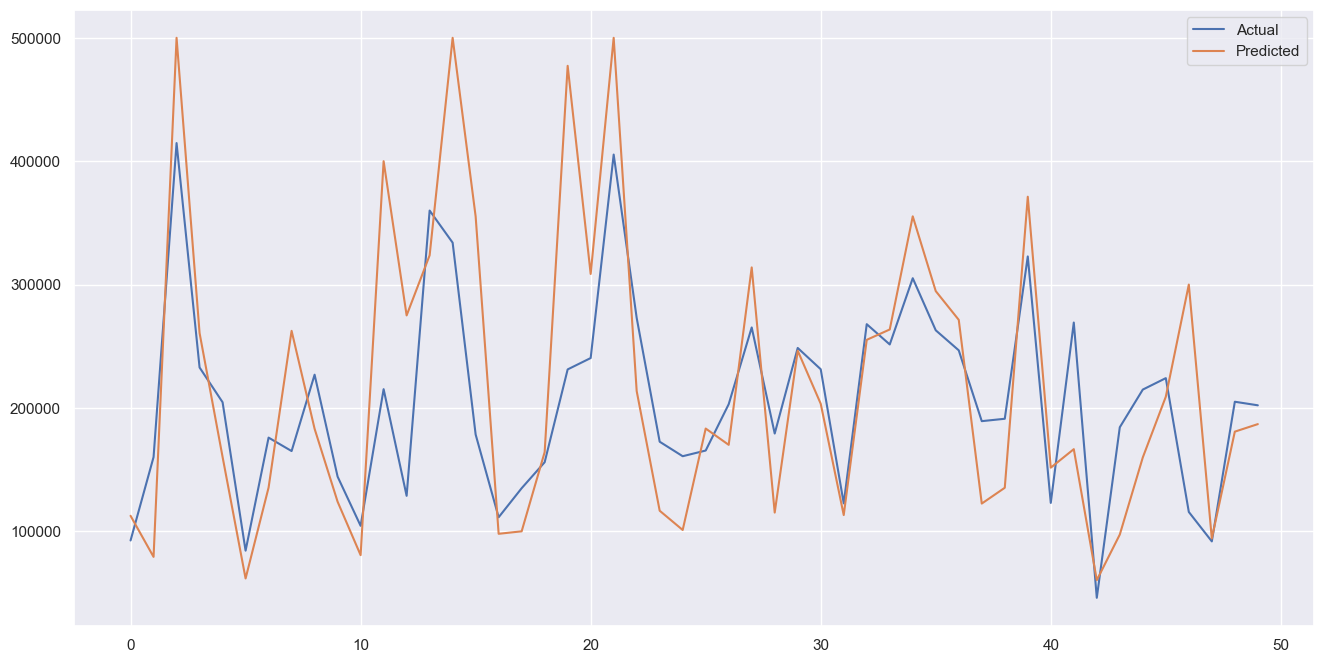

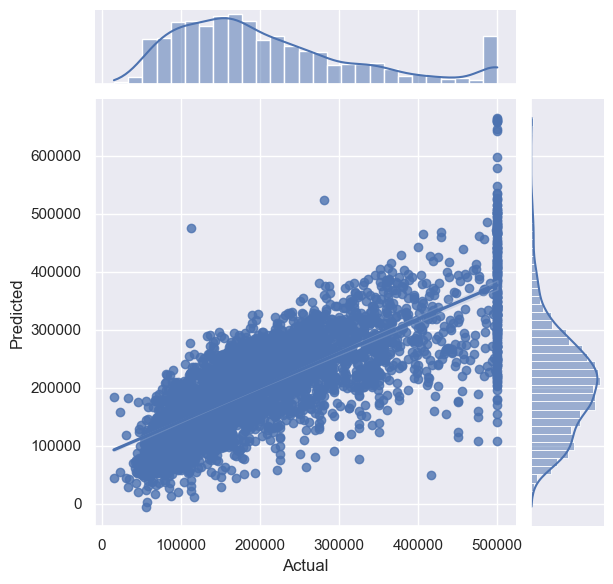

In [27]:
y_pred = reg.predict(X_test)
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind='reg',);

Create an XGBoost regression model: 

In [ ]:
xgb = XGBRegressor()
# your code


In [31]:
# Musterlösung
xgb = XGBRegressor()

xgb.fit(X_train,y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Evaluate the model: 

In [32]:
# Musterlösung
print('training performance')
print(xgb.score(X_train,y_train))
print('test performance')
print(xgb.score(X_test,y_test))

training performance
0.7883895970611186
test performance
0.6280040760379738


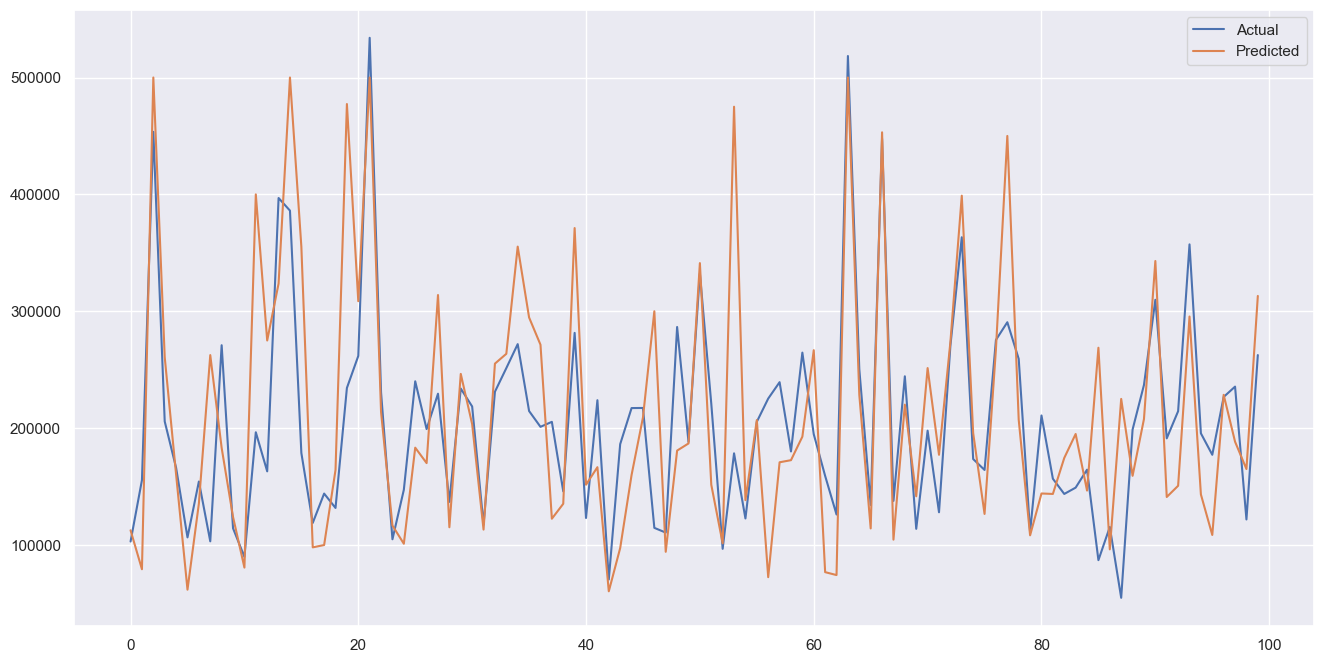

In [33]:
y_pred = xgb.predict(X_test)
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:100])
plt.legend(['Actual','Predicted'])


Interpret the result and feel free to try out further analyses.

_Remarks_ 

- some overfitting for XGBoost
- cf. https://www.kaggle.com/ravichaubey1506/end-to-end-machine-learning for a more advanced example of this use case
- cf. https://people.duke.edu/~rnau/rsquared.htm if you are interested in learning more about evaluating regression models.

## Deployment and model usage

Discuss the following questions
- How could you deploy the model?
- Who could be potential users of the model?
- How could the model be integrated into existing IT infrastructures and digital services? 